In [16]:
"""
Implementation of Grover's Algorithm using Qiskit with minimal dependencies
Compatible with latest Qiskit versions (1.0+)
"""
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt

try:
    from qiskit_aer import AerSimulator
except ImportError:
    print("Error importing AerSimulator. Please install with: pip install qiskit-aer")
    raise

def create_oracle(n_qubits, marked_state):
    """
    Creates a phase oracle that flips the phase of the marked state.
    
    Args:
        n_qubits: Number of qubits in the system
        marked_state: Bit string of the marked state (e.g., '101' for |101⟩)
    
    Returns:
        QuantumCircuit: Oracle circuit
    """
    oracle_circuit = QuantumCircuit(n_qubits)
    
    # Convert marked_state string to a list of 0s and 1s
    marked_state_list = [int(bit) for bit in marked_state]
    
    # Apply X gates to qubits where marked state has 0
    for qubit, bit in enumerate(marked_state_list):
        if bit == 0:
            oracle_circuit.x(qubit)
    
    # Multi-controlled Z gate
    oracle_circuit.h(n_qubits-1)
    
    # Use multi-controlled phase rotation for Z
    controls = list(range(n_qubits-1))
    target = n_qubits-1
    
    # For multi-controlled operations
    oracle_circuit.mcx(controls, target)
    
    oracle_circuit.h(n_qubits-1)
    
    # Apply X gates again to qubits where marked state has 0
    for qubit, bit in enumerate(marked_state_list):
        if bit == 0:
            oracle_circuit.x(qubit)
    
    return oracle_circuit

def create_diffuser(n_qubits):
    """
    Creates the diffusion operator (Grover's diffusion) that amplifies the amplitude
    of the marked state.
    
    Args:
        n_qubits: Number of qubits in the system
    
    Returns:
        QuantumCircuit: Diffuser circuit
    """
    diffuser = QuantumCircuit(n_qubits)
    
    # Apply H gates to all qubits
    diffuser.h(range(n_qubits))
    
    # Apply X gates to all qubits
    diffuser.x(range(n_qubits))
    
    # Apply multi-controlled Z gate
    diffuser.h(n_qubits-1)
    
    # Use multi-controlled X gate
    controls = list(range(n_qubits-1))
    target = n_qubits-1
    diffuser.mcx(controls, target)
    
    diffuser.h(n_qubits-1)
    
    # Apply X gates to all qubits
    diffuser.x(range(n_qubits))
    
    # Apply H gates to all qubits
    diffuser.h(range(n_qubits))
    
    return diffuser

def grover_algorithm(n_qubits, marked_state, num_iterations=None):
    """
    Implements Grover's algorithm for quantum search.
    
    Args:
        n_qubits: Number of qubits in the system
        marked_state: Bit string representing the marked state to search for
        num_iterations: Number of Grover iterations (if None, use optimal)
    
    Returns:
        QuantumCircuit: Complete Grover circuit
    """
    # Initialize circuit with n qubits and n classical bits
    grover_circuit = QuantumCircuit(n_qubits, n_qubits)
    
    # Step 1: Apply Hadamard gates to all qubits
    grover_circuit.h(range(n_qubits))
    
    # Calculate optimal number of iterations if not specified
    if num_iterations is None:
        N = 2**n_qubits  # Total number of states
        num_iterations = int(np.round(np.pi/4 * np.sqrt(N)))
    
    print(f"Using {num_iterations} iterations for {n_qubits} qubits")
    
    # Step 2: Apply Grover's iterations
    oracle = create_oracle(n_qubits, marked_state)
    diffuser = create_diffuser(n_qubits)
    
    for _ in range(num_iterations):
        # Apply oracle
        grover_circuit = grover_circuit.compose(oracle)
        
        # Apply diffuser
        grover_circuit = grover_circuit.compose(diffuser)
    
    # Add measurement
    grover_circuit.measure(range(n_qubits), range(n_qubits))
    
    return grover_circuit

def run_grover(n_qubits, marked_state, shots=1024):
    """
    Executes Grover's algorithm and returns the measurement results.
    
    Args:
        n_qubits: Number of qubits in the system
        marked_state: Bit string representing the marked state
        shots: Number of times to run the circuit
    
    Returns:
        dict: Measurement counts
    """
    # Create the Grover circuit
    circuit = grover_algorithm(n_qubits, marked_state)
    
    # Create simulator
    simulator = AerSimulator()
    
    # Run the circuit
    result = simulator.run(circuit, shots=shots).result()
    
    # Get counts
    counts = result.get_counts(circuit)
    
    return counts

# Example usage
if __name__ == "__main__":
    # Parameters
    n_qubits = 3
    marked_state = '101'  # We want to find the state |101⟩
    
    # Create the circuit
    circuit = grover_algorithm(n_qubits, marked_state)
    
    # Run Grover's algorithm
    counts = run_grover(n_qubits, marked_state)
    
    # Display results
    print(f"Searching for state |{marked_state}⟩ in a {2**n_qubits}-element database")
    print("Measurement results:", counts)
    
    # Plot histogram if available
    try:
        from qiskit.visualization import plot_histogram
        plot_histogram(counts)
        plt.show()
    except ImportError:
        print("Unable to import plot_histogram. Skipping visualization.")
    
    # Show the circuit
    print("Circuit:")
    print(circuit)

Using 2 iterations for 3 qubits
Using 2 iterations for 3 qubits
Searching for state |101⟩ in a 8-element database
Measurement results: {'001': 6, '110': 9, '010': 6, '000': 6, '011': 7, '111': 9, '100': 5, '101': 976}
Circuit:
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐  │  ├───┤├───┤┌───┐       │  ├───┤├───┤┌───┐       │  ├───┤»
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├»
     ├───┤├───┤┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤»
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐               ┌───┐┌───┐     ┌─┐      
«q_0: ┤ X ├────────────■──┤ X

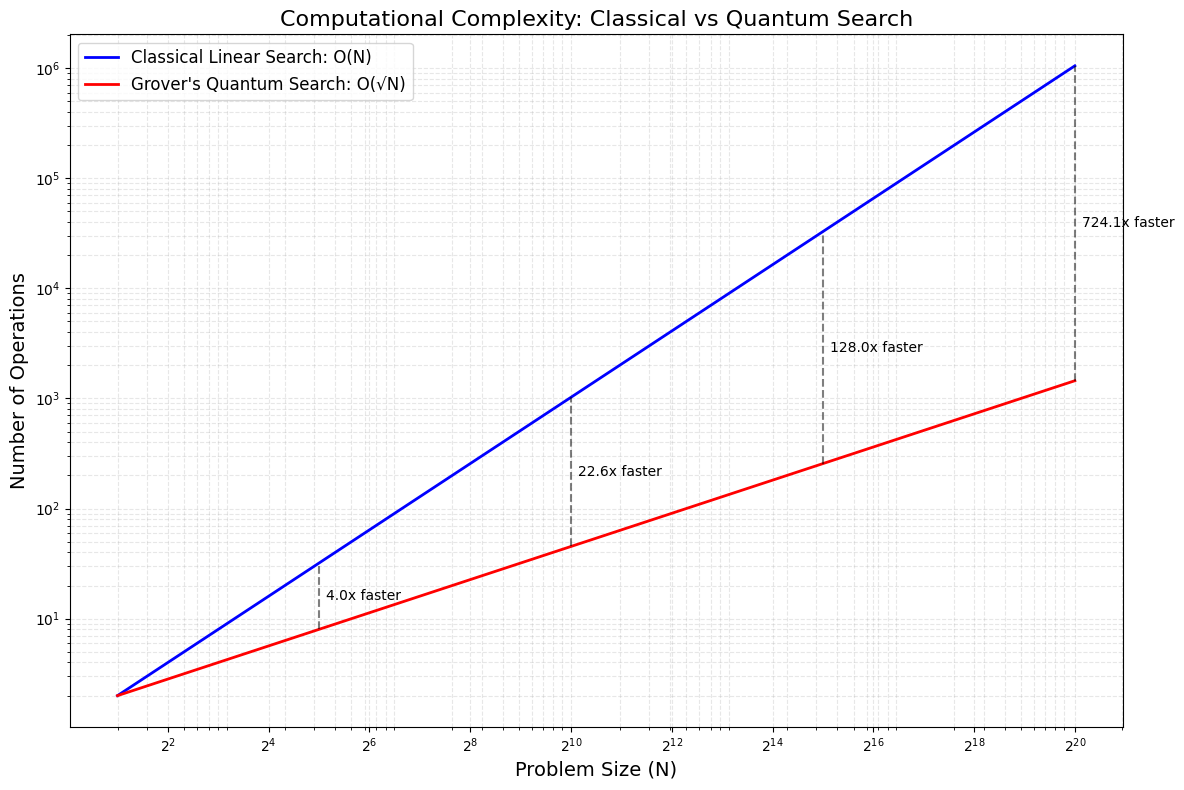

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def compare_complexity_curves():
    """
    Generate and plot the theoretical complexity curves for
    classical linear search and Grover's quantum search algorithm.
    """
    # Range of problem sizes (powers of 2)
    powers = np.arange(1, 21)  # From 2^1 to 2^20
    sizes = 2**powers
    
    # Calculate complexity curves
    # Classical search: O(N)
    classical_complexity = sizes
    
    # Grover's algorithm: O(√N)
    quantum_complexity = np.sqrt(sizes)
    
    # Normalize both curves to start at the same point
    normalization_factor = classical_complexity[0] / quantum_complexity[0]
    quantum_complexity = quantum_complexity * normalization_factor
    
    # Plot the complexity curves
    plt.figure(figsize=(12, 8))
    plt.loglog(sizes, classical_complexity, 'b-', linewidth=2, label='Classical Linear Search: O(N)')
    plt.loglog(sizes, quantum_complexity, 'r-', linewidth=2, label="Grover's Quantum Search: O(√N)")
    
    # Set axis labels and title
    plt.xlabel('Problem Size (N)', fontsize=14)
    plt.ylabel('Number of Operations', fontsize=14)
    plt.title('Computational Complexity: Classical vs Quantum Search', fontsize=16)
    
    # Add grid for easier reading
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    # Customize tick labels
    plt.xticks(
        [2**k for k in range(0, 21, 2)],
        [f'$2^{{{k}}}$' for k in range(0, 21, 2)]
    )
    
    # Add specific data points for visualization
    highlight_powers = [5, 10, 15, 20]
    highlight_sizes = [2**p for p in highlight_powers]
    
    for size in highlight_sizes:
        idx = np.where(sizes == size)[0][0]
        classical_ops = classical_complexity[idx]
        quantum_ops = quantum_complexity[idx]
        
        plt.plot([size, size], [quantum_ops, classical_ops], 'k--', alpha=0.5)
        
        # Calculate and annotate the speedup
        speedup = classical_ops / quantum_ops
        plt.annotate(
            f'{speedup:.1f}x faster',
            xy=(size, np.sqrt(classical_ops * quantum_ops)),
            xytext=(5, 0),
            textcoords='offset points',
            ha='left',
            va='center',
            fontsize=10
        )
    
    # Add legend
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.savefig('complexity_comparison.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    compare_complexity_curves()
